## Krok 1: Import bibliotek

In [1]:
# Importujemy pandas - bibliotekę do pracy z danymi (jak Excel w Pythonie)
import pandas as pd

# Importujemy PyCaret - narzędzie AutoML do klasyfikacji
from pycaret.classification import *

# Importujemy biblioteki do wizualizacji (rysowania wykresów)
import matplotlib.pyplot as plt
import seaborn as sns

# Importujemy numpy do obliczeń numerycznych
import numpy as np

# Importujemy funkcje do tworzenia confusion matrix ze sklearn
from sklearn.metrics import confusion_matrix, classification_report

print("✅ Biblioteki zaimportowane!")

✅ Biblioteki zaimportowane!


## Krok 2: Wczytanie i przygotowanie danych

In [2]:
# Wczytujemy dane o klientach firmy telekomunikacyjnej z pliku CSV
df = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Wyświetlamy podstawowe informacje o danych
print(f"📊 Liczba klientów: {len(df)}")
print(f"📋 Liczba kolumn: {len(df.columns)}")

# Usuwamy kolumnę customerID, bo to tylko numer identyfikacyjny
# Nie pomaga w przewidywaniu (jak numer PESEL - nic nie mówi o zachowaniu klienta)
df = df.drop('customerID', axis=1)

# Naprawiamy kolumnę TotalCharges - konwertujemy teksty na liczby
# Niektóre wartości mogą być tekstem z spacjami zamiast liczb
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Wypełniamy brakujące wartości zerem (nowi klienci mają 0 historii płatności)
df['TotalCharges'].fillna(0, inplace=True)

# Sprawdzamy rozkład churn (ile klientów odchodzi)
print("\n📊 Rozkład churn:")
print(df['Churn'].value_counts())
print(f"\nProcent odchodzących: {(df['Churn'] == 'Yes').sum() / len(df) * 100:.1f}%")

📊 Liczba klientów: 7043
📋 Liczba kolumn: 21

📊 Rozkład churn:
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Procent odchodzących: 26.5%


## Krok 3: Konfiguracja PyCaret

In [3]:
# Inicjalizujemy PyCaret - przygotowujemy środowisko do uczenia maszynowego
# data = nasze dane
# target = kolumna, którą chcemy przewidzieć (Churn: Yes/No)
# session_id = ustawienie losowości dla powtarzalnych wyników
# train_size = 80% danych do nauki, 20% do testowania
# fold = 5-fold cross-validation (dzielimy dane na 5 części dla lepszej oceny)
# normalize = normalizacja danych numerycznych (skalowanie do podobnego zakresu)

clf_setup = setup(
    data=df,
    target='Churn',
    session_id=123,
    train_size=0.8,
    fold=5,
    normalize=True,
    verbose=False
)

print("\n✅ PyCaret skonfigurowany!")


✅ PyCaret skonfigurowany!


## Krok 4: Trening modelu z optymalizacją pod RECALL

### Co to jest Recall?
**Recall** = Ile % faktycznie odchodzących klientów wykrywamy

Przykład:
- Jest 100 klientów, którzy faktycznie odejdą
- Model wykrywa 80 z nich
- **Recall = 80%**

### Dlaczego optymalizujemy pod Recall?
W churn **gorsze jest przegapienie klienta** (który odejdzie) niż fałszywy alarm.

In [4]:
# Porównujemy różne algorytmy ML
# sort='Recall' - sortujemy modele według Recall (chcemy wykryć jak najwięcej odejść!)
# n_select=1 - wybieramy tylko najlepszy model

print("🔄 Porównujemy modele z optymalizacją pod RECALL...")
print("Szukamy modelu, który wykryje NAJWIĘCEJ klientów zagrożonych odejściem!\n")

# Porównujemy wszystkie dostępne modele
best_model = compare_models(sort='Recall', n_select=1)

print("\n✅ Najlepszy model (pod kątem Recall) wybrany!")

🔄 Porównujemy modele z optymalizacją pod RECALL...
Szukamy modelu, który wykryje NAJWIĘCEJ klientów zagrożonych odejściem!



,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8039,0.8457,0.8039,0.7967,0.7985,0.4720,0.4753,1.0860
ada,Ada Boost Classifier,0.8019,0.8441,0.8019,0.7936,0.7953,0.4617,0.4661,0.2000
ridge,Ridge Classifier,0.8003,0.8373,0.8003,0.7908,0.7921,0.4508,0.4571,0.1240
gbc,Gradient Boosting Classifier,0.7993,0.8463,0.7993,0.7903,0.7924,0.4534,0.4578,0.3760
lda,Linear Discriminant Analysis,0.7971,0.8372,0.7971,0.7906,0.7927,0.4586,0.4607,0.1180
rf,Random Forest Classifier,0.7913,0.8248,0.7913,0.7802,0.7823,0.4242,0.4302,0.2180
lightgbm,Light Gradient Boosting Machine,0.7900,0.8359,0.7900,0.7811,0.7837,0.4321,0.4352,0.3040
svm,SVM - Linear Kernel,0.7815,0.8202,0.7815,0.7803,0.7805,0.4351,0.4358,0.1340
et,Extra Trees Classifier,0.7746,0.7984,0.7746,0.7630,0.7663,0.3839,0.3880,0.2320
knn,K Neighbors Classifier,0.7581,0.7739,0.7581,0.7535,0.7552,0.3657,0.3667,0.8920



✅ Najlepszy model (pod kątem Recall) wybrany!


## Krok 5: Wyświetlenie Confusion Matrix dla modelu

📊 Confusion Matrix - Macierz pomyłek

Co pokazuje:
  - True Negative (TN): Prawidłowo przewidziane 'klient zostaje' ✅
  - False Positive (FP): Fałszywy alarm - klient nie odszedł, ale model myślał że tak ❌
  - False Negative (FN): Przegapiony - klient odszedł, model nie wykrył ❌❌❌
  - True Positive (TP): Prawidłowo wykryty odchodzący klient ✅✅



,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7950,0.8328,0.7950,0.7893,0.7916,0.4574,0.4585
1,0.8075,0.8464,0.8075,0.7994,0.8016,0.4788,0.4822
2,0.7933,0.8454,0.7933,0.7871,0.7895,0.4515,0.4527
3,0.7959,0.8397,0.7959,0.7878,0.7905,0.4507,0.4532
4,0.8277,0.8640,0.8277,0.8200,0.8195,0.5215,0.5299
Mean,0.8039,0.8457,0.8039,0.7967,0.7985,0.4720,0.4753
Std,0.0129,0.0104,0.0129,0.0125,0.0114,0.0268,0.0294


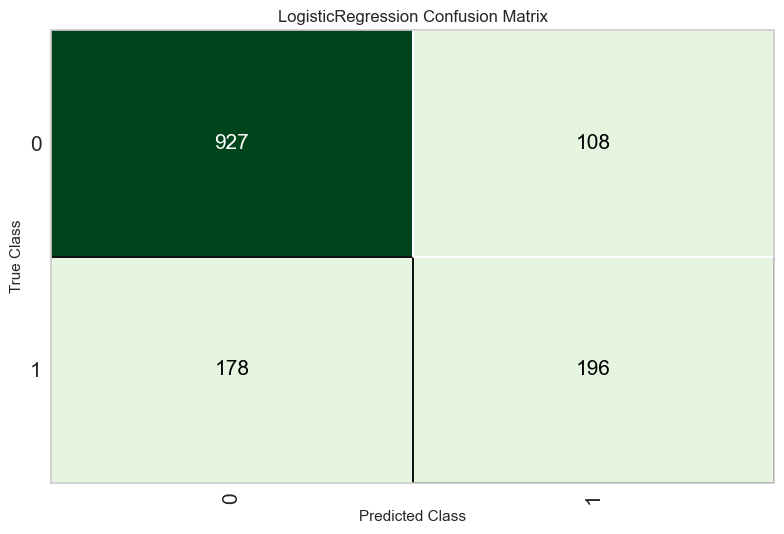

In [6]:
# Wyświetlamy Confusion Matrix - macierz pomyłek
# To tabela pokazująca ile przewidywań było prawidłowych/błędnych

print("📊 Confusion Matrix - Macierz pomyłek")
print("\nCo pokazuje:")
print("  - True Negative (TN): Prawidłowo przewidziane 'klient zostaje' ✅")
print("  - False Positive (FP): Fałszywy alarm - klient nie odszedł, ale model myślał że tak ❌")
print("  - False Negative (FN): Przegapiony - klient odszedł, model nie wykrył ❌❌❌")
print("  - True Positive (TP): Prawidłowo wykryty odchodzący klient ✅✅\n")

# Tworzymy model jeszcze raz z pełnymi szczegółami
final_model = create_model(best_model)

# Wyświetlamy confusion matrix
plot_model(final_model, plot='confusion_matrix')

## Krok 5a: Tuning modelu pod kątem RECALL

### Co to jest tuning?
**Tuning** = optymalizacja hiperparametrów modelu pod konkretną metrykę.

W poprzednim kroku `compare_models` **tylko wybrał** najlepszy algorytm.
Teraz `tune_model` będzie **optymalizował** jego parametry pod kątem **Recall**.

### Czy tuning ma sens?
Sprawdzimy czy **faktycznie** tuning poprawia Recall na tyle, żeby był wart dodatkowego czasu i złożoności.

In [20]:
# Zapisujemy metryki modelu PRZED tuningiem
print("="*80)
print("📊 MODEL BAZOWY (przed tuningiem)")
print("="*80)

# Pobieramy metryki modelu bazowego z cross-validation
baseline_metrics = pull()

# Sprawdzamy jakie kolumny są dostępne (PyCaret 3.x używa skróconych nazw)
print("\n🔍 Dostępne metryki:", list(baseline_metrics.columns))

# Używamy poprawnych nazw kolumn z PyCaret 3.x
baseline_recall = baseline_metrics.loc['Mean', 'Recall']
baseline_precision = baseline_metrics.loc['Mean', 'Prec.']  # PyCaret 3.x używa 'Prec.' zamiast 'Precision'
baseline_accuracy = baseline_metrics.loc['Mean', 'Accuracy']
baseline_auc = baseline_metrics.loc['Mean', 'AUC']

print(f"\n📈 Metryki modelu bazowego (cross-validation):")
print(f"   Recall:    {baseline_recall:.4f}")
print(f"   Precision: {baseline_precision:.4f}")
print(f"   Accuracy:  {baseline_accuracy:.4f}")
print(f"   AUC:       {baseline_auc:.4f}")

# Teraz TUNUJEMY model pod kątem Recall
# optimize='Recall' - szukamy najlepszych parametrów dla maksymalnego Recall
# n_iter=20 - próbujemy 20 różnych kombinacji parametrów
print("\n" + "="*80)
print("🔧 TUNING - Optymalizacja modelu pod kątem RECALL")
print("="*80)
print("Szukamy najlepszych hiperparametrów dla maksymalnego Recall...")
print("To może zająć 1-2 minuty...\n")

tuned_model = tune_model(final_model, optimize='Recall', n_iter=20)

print("\n✅ Tuning zakończony!")

# Pobieramy metryki po tuningu
tuned_metrics = pull()
tuned_recall = tuned_metrics.loc['Mean', 'Recall']
tuned_precision = tuned_metrics.loc['Mean', 'Prec.']  # PyCaret 3.x używa 'Prec.'
tuned_accuracy = tuned_metrics.loc['Mean', 'Accuracy']
tuned_auc = tuned_metrics.loc['Mean', 'AUC']

print("\n" + "="*80)
print("📊 MODEL PO TUNINGU")
print("="*80)
print(f"\n📈 Metryki modelu po tuningu (cross-validation):")
print(f"   Recall:    {tuned_recall:.4f}")
print(f"   Precision: {tuned_precision:.4f}")
print(f"   Accuracy:  {tuned_accuracy:.4f}")
print(f"   AUC:       {tuned_auc:.4f}")


📊 MODEL BAZOWY (przed tuningiem)

🔍 Dostępne metryki: ['Accuracy', 'AUC', 'Recall', 'Prec.', 'F1', 'Kappa', 'MCC']

📈 Metryki modelu bazowego (cross-validation):
   Recall:    0.8039
   Precision: 0.7967
   Accuracy:  0.8039
   AUC:       0.8457

🔧 TUNING - Optymalizacja modelu pod kątem RECALL
Szukamy najlepszych hiperparametrów dla maksymalnego Recall...
To może zająć 1-2 minuty...



,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7950,0.8330,0.7950,0.7893,0.7916,0.4574,0.4585
1,0.8048,0.8471,0.8048,0.7970,0.7993,0.4734,0.4763
2,0.7950,0.8455,0.7950,0.7897,0.7918,0.4586,0.4595
3,0.7968,0.8400,0.7968,0.7886,0.7912,0.4524,0.4551
4,0.8295,0.8636,0.8295,0.8220,0.8211,0.5253,0.5344
Mean,0.8042,0.8458,0.8042,0.7973,0.7990,0.4734,0.4767
Std,0.0131,0.0102,0.0131,0.0127,0.0114,0.0269,0.0297


Fitting 5 folds for each of 20 candidates, totalling 100 fits

✅ Tuning zakończony!

📊 MODEL PO TUNINGU

📈 Metryki modelu po tuningu (cross-validation):
   Recall:    0.8042
   Precision: 0.7973
   Accuracy:  0.8042
   AUC:       0.8458


In [21]:
# PORÓWNANIE - Czy tuning się opłacił?
print("\n" + "="*80)
print("⚖️ PORÓWNANIE: BAZOWY vs TUNED")
print("="*80)

# Obliczamy różnice w punktach procentowych (p.p.)
recall_diff = (tuned_recall - baseline_recall) * 100
precision_diff = (tuned_precision - baseline_precision) * 100
accuracy_diff = (tuned_accuracy - baseline_accuracy) * 100
auc_diff = (tuned_auc - baseline_auc) * 100

print(f"\n📊 Zmiana metryk po tuningu:")
print(f"   Recall:    {baseline_recall:.4f} → {tuned_recall:.4f}  ({recall_diff:+.2f} p.p.)")
print(f"   Precision: {baseline_precision:.4f} → {tuned_precision:.4f}  ({precision_diff:+.2f} p.p.)")
print(f"   Accuracy:  {baseline_accuracy:.4f} → {tuned_accuracy:.4f}  ({accuracy_diff:+.2f} p.p.)")
print(f"   AUC:       {baseline_auc:.4f} → {tuned_auc:.4f}  ({auc_diff:+.2f} p.p.)")

# DECYZJA: Który model wybrać?
# Uznajemy że tuning ma sens jeśli poprawa Recall ≥ 1 punkt procentowy
THRESHOLD_FOR_IMPROVEMENT = 1.0  # 1 punkt procentowy

print("\n" + "="*80)
print("🎯 DECYZJA: KTÓRY MODEL WYBRAĆ?")
print("="*80)

if recall_diff >= THRESHOLD_FOR_IMPROVEMENT:
    print(f"\n✅ TUNING OPŁACALNY!")
    print(f"   Recall poprawił się o {recall_diff:.2f} p.p. (≥ {THRESHOLD_FOR_IMPROVEMENT} p.p.)")
    print(f"   Używamy MODELU PO TUNINGU do dalszej analizy.")
    selected_model = tuned_model
    model_name = "TUNED"
else:
    print(f"\n❌ TUNING NIE WART ZACHODU")
    print(f"   Recall poprawił się tylko o {recall_diff:.2f} p.p. (< {THRESHOLD_FOR_IMPROVEMENT} p.p.)")
    print(f"   Używamy MODELU BAZOWEGO - prostszy i szybszy!")
    selected_model = final_model
    model_name = "BAZOWY"

print(f"\n💡 Wybrany model: {model_name}")
print(f"   Recall: {tuned_recall:.4f}" if model_name == "TUNED" else f"   Recall: {baseline_recall:.4f}")


⚖️ PORÓWNANIE: BAZOWY vs TUNED

📊 Zmiana metryk po tuningu:
   Recall:    0.8039 → 0.8042  (+0.03 p.p.)
   Precision: 0.7967 → 0.7973  (+0.06 p.p.)
   Accuracy:  0.8039 → 0.8042  (+0.03 p.p.)
   AUC:       0.8457 → 0.8458  (+0.01 p.p.)

🎯 DECYZJA: KTÓRY MODEL WYBRAĆ?

❌ TUNING NIE WART ZACHODU
   Recall poprawił się tylko o 0.03 p.p. (< 1.0 p.p.)
   Używamy MODELU BAZOWEGO - prostszy i szybszy!

💡 Wybrany model: BAZOWY
   Recall: 0.8039


## Krok 6: Pobieranie danych testowych i przewidywań

**Używamy modelu wybranego w kroku 5a** (bazowy lub tuned - w zależności od tego, który ma lepszy Recall).

In [22]:
# 🔍 CO ROBIMY W TYM KROKU?
# Przygotowujemy dane do późniejszej analizy (krok 7-12)
# To jak przygotowanie składników przed gotowaniem - kroiszz cebulę zanim ją smażysz!

# 1️⃣ Pobieramy dane testowe (20% danych, których model NIE widział podczas treningu)
# Skąd to się bierze? Z setup() w kroku 3 - PyCaret automatycznie podzielił dane 80/20

# X_test = CECHY klientów (wszystkie kolumny OPRÓCZ Churn)
# To są informacje opisujące klienta, np:
#   - tenure (ile miesięcy jest klientem)
#   - MonthlyCharges (miesięczny rachunek)
#   - Contract (typ umowy: miesięczna/roczna)
#   - InternetService (czy ma internet)
#   - PaymentMethod (jak płaci)
#   ... i wiele innych (19 kolumn!)
X_test = get_config('X_test')

# y_test = ODPOWIEDŹ którą chcemy przewidzieć
# Czy klient faktycznie odszedł? (Yes/No)
y_test = get_config('y_test')

print(f"📊 Mamy {len(X_test)} klientów testowych")
print(f"📋 Każdy klient opisany przez {len(X_test.columns)} cech (kolumn)")
print(f"\n🔍 Przykładowe cechy (pierwsze 5 kolumn): {list(X_test.columns[:5])}")
print(f"🔍 Przykładowe prawdziwe etykiety: {y_test.iloc[:5].values}")

# 2️⃣ Zamieniamy etykiety tekstowe na liczby (Yes=1, No=0)
# DLACZEGO? W kroku 7 będziemy obliczać confusion matrix - to wymaga liczb
# To przygotowanie na przyszłość - nie używamy tego od razu!
y_test_numeric = (y_test == 'Yes').astype(int)

print(f"🔢 Zamienione na liczby: {y_test_numeric.iloc[:5].values}")
print("   (0 = klient zostaje, 1 = klient odchodzi)")

# 3️⃣ Pobieramy przewidywania modelu (prawdopodobieństwa)
# predict_model używa WYBRANEGO modelu (bazowy lub tuned) i danych X_test
# Model patrzy na CECHY klienta (X_test) i oblicza prawdopodobieństwo odejścia
print(f"\n🤖 Używamy modelu: {model_name}")
predictions = predict_model(selected_model, data=X_test)

# 4️⃣ Wyciągamy prawdopodobieństwa odejścia (0.0 - 1.0)
# prediction_score to szansa że klient odejdzie
# Np. 0.75 = model myśli że 75% szans że klient odejdzie
# Np. 0.23 = model myśli że 23% szans że klient odejdzie (zostanie)
y_proba = predictions['prediction_score'].values

print(f"\n✅ Gotowe! Przygotowano dane do analizy thresholdów")
print(f"📊 Przykładowe prawdopodobieństwa odejścia: {y_proba[:5]}")
print("\n💡 PODSUMOWANIE:")
print(f"   X_test = {len(X_test.columns)} cech opisujących klienta")
print(f"   y_test = prawdziwa odpowiedź (czy odszedł)")
print(f"   y_proba = przewidywane prawdopodobieństwo (0.0-1.0)")


📊 Mamy 1409 klientów testowych
📋 Każdy klient opisany przez 19 cech (kolumn)

🔍 Przykładowe cechy (pierwsze 5 kolumn): ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure']
🔍 Przykładowe prawdziwe etykiety: ['No', 'No', 'Yes', 'No', 'Yes']
Categories (2, object): ['No', 'Yes']
🔢 Zamienione na liczby: [0 0 1 0 1]
   (0 = klient zostaje, 1 = klient odchodzi)

🤖 Używamy modelu: BAZOWY



✅ Gotowe! Przygotowano dane do analizy thresholdów
📊 Przykładowe prawdopodobieństwa odejścia: [0.9968 0.8205 0.9746 0.9861 0.5952]

💡 PODSUMOWANIE:
   X_test = 19 cech opisujących klienta
   y_test = prawdziwa odpowiedź (czy odszedł)
   y_proba = przewidywane prawdopodobieństwo (0.0-1.0)


In [23]:
# Zobaczmy przykładowego klienta z X_test (jego cechy)
print("="*80)
print("👤 PRZYKŁADOWY KLIENT - CO WIEMY O NIM?")
print("="*80)
print("\nCechy pierwszego klienta testowego:")
print(X_test.iloc[0])

print("\n" + "="*80)
print("❓ CZY TEN KLIENT FAKTYCZNIE ODSZEDŁ?")
print("="*80)
print(f"Prawdziwa odpowiedź (y_test): {y_test.iloc[0]}")
print(f"W liczbach (y_test_numeric): {y_test_numeric.iloc[0]} (0=zostaje, 1=odchodzi)")

print("\n" + "="*80)
print("🤖 CO MODEL PRZEWIDUJE?")
print("="*80)
print(f"Prawdopodobieństwo odejścia (y_proba): {y_proba[0]:.3f} ({y_proba[0]*100:.1f}%)")

print("\n💡 Model widzi cechy klienta (X_test) i oblicza prawdopodobieństwo odejścia!")


👤 PRZYKŁADOWY KLIENT - CO WIEMY O NIM?

Cechy pierwszego klienta testowego:
gender                               Female
SeniorCitizen                             0
Partner                                 Yes
Dependents                               No
tenure                                   69
PhoneService                            Yes
MultipleLines                           Yes
InternetService                          No
OnlineSecurity          No internet service
OnlineBackup            No internet service
DeviceProtection        No internet service
TechSupport             No internet service
StreamingTV             No internet service
StreamingMovies         No internet service
Contract                           Two year
PaperlessBilling                        Yes
PaymentMethod       Credit card (automatic)
MonthlyCharges                    24.950001
TotalCharges                    1718.349976
Name: 3120, dtype: object

❓ CZY TEN KLIENT FAKTYCZNIE ODSZEDŁ?
Prawdziwa odpowiedź (y_t

## Krok 7: Funkcja do obliczania Confusion Matrix dla różnych thresholdów

In [24]:
# Definiujemy funkcję, która oblicza confusion matrix dla danego threshold
# Threshold = próg decyzyjny: powyżej niego mówimy "klient odejdzie"

def calculate_confusion_matrix(y_true, y_proba, threshold):
    """
    Oblicza confusion matrix dla danego threshold.
    
    y_true: prawdziwe etykiety (0 lub 1)
    y_proba: prawdopodobieństwa z modelu (0.0 - 1.0)
    threshold: próg decyzyjny (np. 0.5 = 50%)
    """
    # Konwertujemy prawdopodobieństwa na decyzje (0 lub 1)
    # Jeśli prawdopodobieństwo >= threshold → przewidujemy "odejdzie" (1)
    # Jeśli prawdopodobieństwo < threshold → przewidujemy "zostaje" (0)
    y_pred = (y_proba >= threshold).astype(int)
    
    # Obliczamy confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Wyciągamy wartości z macierzy
    tn, fp, fn, tp = cm.ravel()
    
    # Obliczamy metryki
    # Recall = TP / (TP + FN) - ile % faktycznych odejść wykrywamy
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    # Precision = TP / (TP + FP) - ile % naszych alarmów jest trafnych
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    # Accuracy = (TP + TN) / All - ogólna dokładność
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    # Zwracamy wyniki jako słownik (mapa klucz-wartość)
    return {
        'threshold': threshold,
        'confusion_matrix': cm,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'tp': tp,
        'recall': recall,
        'precision': precision,
        'accuracy': accuracy
    }

print("✅ Funkcja zdefiniowana!")

✅ Funkcja zdefiniowana!


## Krok 8: Testowanie różnych thresholdów (0.3, 0.5, 0.7)

In [25]:
# Testujemy 3 różne progi decyzyjne
# 0.3 = liberalny (dużo alarmów, mało przegapionych)
# 0.5 = standardowy (balans)
# 0.7 = konserwatywny (mało alarmów, więcej przegapionych)

thresholds = [0.3, 0.5, 0.7]

# Przechowujemy wyniki dla każdego threshold
results = []

# Dla każdego progu obliczamy confusion matrix
for threshold in thresholds:
    # Obliczamy metryki dla tego threshold
    result = calculate_confusion_matrix(y_test_numeric, y_proba, threshold)
    # Dodajemy do listy wyników
    results.append(result)

print("✅ Obliczono confusion matrix dla wszystkich thresholdów!")

✅ Obliczono confusion matrix dla wszystkich thresholdów!


## Krok 9: Wizualizacja Confusion Matrix dla różnych thresholdów

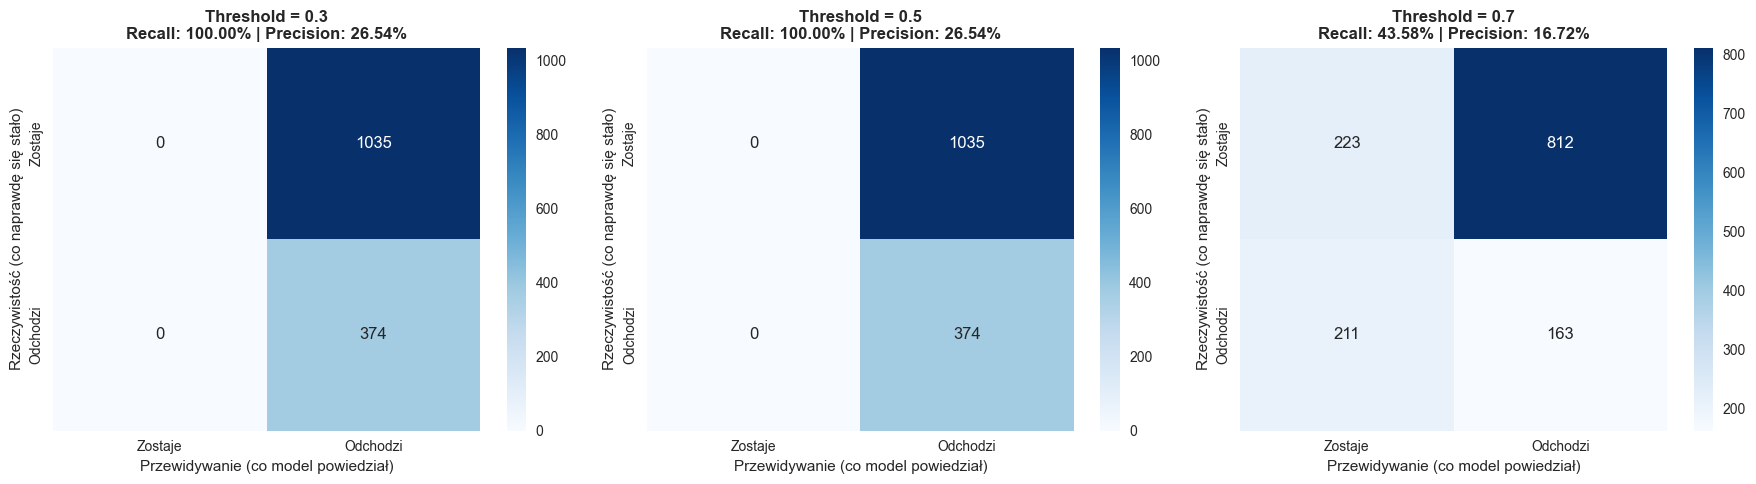


📊 Powyżej widzisz jak zmienia się Confusion Matrix przy różnych thresholdach!


In [26]:
# Tworzymy wykres z 3 confusion matrices obok siebie
# figsize=(18, 5) - szeroki wykres żeby zmieściły się 3 macierze
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Dla każdego wyniku rysujemy confusion matrix
for idx, result in enumerate(results):
    # idx = numer wykresu (0, 1, 2)
    # result = wyniki dla danego threshold
    
    # Pobieramy confusion matrix z wyniku
    cm = result['confusion_matrix']
    
    # Rysujemy heatmap (mapę ciepła) - im większa wartość, tym ciemniejszy kolor
    # annot=True - pokazuj liczby w komórkach
    # fmt='d' - formatuj liczby jako integer (bez przecinka)
    # cmap='Blues' - używaj niebieskiej palety kolorów
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Zostaje', 'Odchodzi'],
                yticklabels=['Zostaje', 'Odchodzi'])
    
    # Ustawiamy tytuł wykresu z wartościami metryk
    axes[idx].set_title(
        f"Threshold = {result['threshold']}\n"
        f"Recall: {result['recall']:.2%} | Precision: {result['precision']:.2%}",
        fontsize=12, fontweight='bold'
    )
    
    # Podpisujemy osie
    axes[idx].set_ylabel('Rzeczywistość (co naprawdę się stało)')
    axes[idx].set_xlabel('Przewidywanie (co model powiedział)')

# Dopasowujemy layout żeby wykresy się nie nakładały
plt.tight_layout()

# Wyświetlamy wykres
plt.show()

print("\n📊 Powyżej widzisz jak zmienia się Confusion Matrix przy różnych thresholdach!")

## Krok 10: Szczegółowe porównanie metryk

In [27]:
# Wyświetlamy szczegółowe porównanie dla każdego threshold
print("="*80)
print("📊 SZCZEGÓŁOWE PORÓWNANIE THRESHOLDÓW")
print("="*80)

# Dla każdego wyniku wyświetlamy metryki
for result in results:
    print(f"\n{'='*80}")
    print(f"🎯 THRESHOLD = {result['threshold']} ({result['threshold']*100:.0f}% prawdopodobieństwa)")
    print(f"{'='*80}")
    
    # Wyświetlamy wartości z confusion matrix
    print(f"\n📈 CONFUSION MATRIX:")
    print(f"   ✅ True Negative (TN):  {result['tn']:4d} - Prawidłowo: 'klient zostaje'")
    print(f"   ⚠️  False Positive (FP): {result['fp']:4d} - Fałszywy alarm (niepotrzebny telefon)")
    print(f"   ❌ False Negative (FN): {result['fn']:4d} - Przegapiony (klient odszedł!)")
    print(f"   ✅ True Positive (TP):  {result['tp']:4d} - Prawidłowo wykryty odchodzący")
    
    # Wyświetlamy metryki
    print(f"\n📊 METRYKI:")
    print(f"   Recall:    {result['recall']:.2%} - wykrywamy {result['recall']*100:.1f}% odchodzących")
    print(f"   Precision: {result['precision']:.2%} - {result['precision']*100:.1f}% naszych alarmów jest trafnych")
    print(f"   Accuracy:  {result['accuracy']:.2%} - ogólna dokładność")

print(f"\n{'='*80}")

📊 SZCZEGÓŁOWE PORÓWNANIE THRESHOLDÓW

🎯 THRESHOLD = 0.3 (30% prawdopodobieństwa)

📈 CONFUSION MATRIX:
   ✅ True Negative (TN):     0 - Prawidłowo: 'klient zostaje'
   ⚠️  False Positive (FP): 1035 - Fałszywy alarm (niepotrzebny telefon)
   ❌ False Negative (FN):    0 - Przegapiony (klient odszedł!)
   ✅ True Positive (TP):   374 - Prawidłowo wykryty odchodzący

📊 METRYKI:
   Recall:    100.00% - wykrywamy 100.0% odchodzących
   Precision: 26.54% - 26.5% naszych alarmów jest trafnych
   Accuracy:  26.54% - ogólna dokładność

🎯 THRESHOLD = 0.5 (50% prawdopodobieństwa)

📈 CONFUSION MATRIX:
   ✅ True Negative (TN):     0 - Prawidłowo: 'klient zostaje'
   ⚠️  False Positive (FP): 1035 - Fałszywy alarm (niepotrzebny telefon)
   ❌ False Negative (FN):    0 - Przegapiony (klient odszedł!)
   ✅ True Positive (TP):   374 - Prawidłowo wykryty odchodzący

📊 METRYKI:
   Recall:    100.00% - wykrywamy 100.0% odchodzących
   Precision: 26.54% - 26.5% naszych alarmów jest trafnych
   Accuracy:  26.54%

## Krok 11: Analiza biznesowa - Trade-off Recall vs Precision

In [28]:
# Założenia biznesowe dla analizy
# Ile kosztuje przegapienie klienta vs fałszywy alarm?

# Koszt fałszywego alarmu (FP) - dzwonimy do klienta, który i tak by został
cost_false_positive = 20  # 20 zł - telefon + czas konsultanta

# Koszt przegapienia odejścia (FN) - klient odchodzi, nie próbujemy go zatrzymać
cost_false_negative = 500  # 500 zł - wartość roczna klienta

# Korzyść z prawidłowego wykrycia (TP) - dzwonimy, zatrzymujemy 30% klientów
retention_rate = 0.30  # 30% szans na zatrzymanie
value_retained_customer = 500  # 500 zł wartość zatrzymanego klienta
cost_retention_attempt = 50  # 50 zł - koszt próby zatrzymania (telefon + oferta)

print("="*80)
print("💰 ANALIZA BIZNESOWA - KTÓRY THRESHOLD JEST NAJLEPSZY?")
print("="*80)

print(f"\n📋 Założenia:")
print(f"   - Koszt fałszywego alarmu (FP): {cost_false_positive} zł")
print(f"   - Koszt przegapienia klienta (FN): {cost_false_negative} zł")
print(f"   - Koszt próby retencji: {cost_retention_attempt} zł")
print(f"   - Skuteczność retencji: {retention_rate*100:.0f}%")
print(f"   - Wartość zatrzymanego klienta: {value_retained_customer} zł")

# Dla każdego threshold obliczamy koszty
for result in results:
    print(f"\n{'='*80}")
    print(f"🎯 THRESHOLD = {result['threshold']}")
    print(f"{'='*80}")
    
    # Obliczamy koszty
    # Koszt fałszywych alarmów
    cost_fp = result['fp'] * cost_false_positive
    
    # Koszt przegapionych klientów
    cost_fn = result['fn'] * cost_false_negative
    
    # Koszt prób retencji dla prawidłowo wykrytych
    cost_tp = result['tp'] * cost_retention_attempt
    
    # Przychód z zatrzymanych klientów (30% z TP)
    revenue_tp = result['tp'] * retention_rate * value_retained_customer
    
    # Całkowity koszt
    total_cost = cost_fp + cost_fn + cost_tp
    
    # Całkowity przychód
    total_revenue = revenue_tp
    
    # Zysk netto
    net_profit = total_revenue - total_cost
    
    # Wyświetlamy wyniki
    print(f"\n💸 KOSZTY:")
    print(f"   Fałszywe alarmy (FP={result['fp']}): {cost_fp:,} zł")
    print(f"   Przegapieni klienci (FN={result['fn']}): {cost_fn:,} zł")
    print(f"   Próby retencji (TP={result['tp']}): {cost_tp:,} zł")
    print(f"   ─────────────────────────────")
    print(f"   SUMA KOSZTÓW: {total_cost:,} zł")
    
    print(f"\n💰 PRZYCHODY:")
    print(f"   Zatrzymani klienci ({result['tp']*retention_rate:.0f} z {result['tp']}): {revenue_tp:,} zł")
    
    print(f"\n📊 BILANS:")
    if net_profit >= 0:
        print(f"   ✅ ZYSK: {net_profit:,} zł")
    else:
        print(f"   ❌ STRATA: {abs(net_profit):,} zł")

print(f"\n{'='*80}")

💰 ANALIZA BIZNESOWA - KTÓRY THRESHOLD JEST NAJLEPSZY?

📋 Założenia:
   - Koszt fałszywego alarmu (FP): 20 zł
   - Koszt przegapienia klienta (FN): 500 zł
   - Koszt próby retencji: 50 zł
   - Skuteczność retencji: 30%
   - Wartość zatrzymanego klienta: 500 zł

🎯 THRESHOLD = 0.3

💸 KOSZTY:
   Fałszywe alarmy (FP=1035): 20,700 zł
   Przegapieni klienci (FN=0): 0 zł
   Próby retencji (TP=374): 18,700 zł
   ─────────────────────────────
   SUMA KOSZTÓW: 39,400 zł

💰 PRZYCHODY:
   Zatrzymani klienci (112 z 374): 56,100.0 zł

📊 BILANS:
   ✅ ZYSK: 16,700.0 zł

🎯 THRESHOLD = 0.5

💸 KOSZTY:
   Fałszywe alarmy (FP=1035): 20,700 zł
   Przegapieni klienci (FN=0): 0 zł
   Próby retencji (TP=374): 18,700 zł
   ─────────────────────────────
   SUMA KOSZTÓW: 39,400 zł

💰 PRZYCHODY:
   Zatrzymani klienci (112 z 374): 56,100.0 zł

📊 BILANS:
   ✅ ZYSK: 16,700.0 zł

🎯 THRESHOLD = 0.7

💸 KOSZTY:
   Fałszywe alarmy (FP=812): 16,240 zł
   Przegapieni klienci (FN=211): 105,500 zł
   Próby retencji (TP=163): 8

## Krok 12: Wnioski - Który threshold wybrać?

In [30]:
# Znajdźmy najlepszy threshold pod kątem zysku
print("="*80)
print("🎯 WNIOSKI - KTÓRY THRESHOLD WYBRAĆ?")
print("="*80)

print("\n📊 PORÓWNANIE TRADE-OFF:")
print("\n1️⃣ THRESHOLD 0.3 (Liberalny - więcej alarmów):")
print("   ✅ Wykrywamy najwięcej odchodzących klientów (wysoki Recall)")
print("   ❌ Dużo fałszywych alarmów (niski Precision)")
print("   💡 Wybierz gdy: Koszt przegapienia >> Koszt fałszywego alarmu")
print("   📞 Przykład: Dziś dzwonimy do wielu klientów (niepotrzebnie)")

print("\n2️⃣ THRESHOLD 0.5 (Standardowy - balans):")
print("   ⚖️ Balans między Recall a Precision")
print("   💡 Standardowe podejście - rozsądny kompromis")
print("   📞 Przykład: Dzwonimy do średniej liczby klientów")

print("\n3️⃣ THRESHOLD 0.7 (Konserwatywny - mało alarmów):")
print("   ✅ Mało fałszywych alarmów (wysoki Precision)")
print("   ❌ Przegapiamy więcej odchodzących (niski Recall)")
print("   💡 Wybierz gdy: Koszt fałszywego alarmu >> Koszt przegapienia")
print("   📞 Przykład: Dzwonimy tylko do naprawdę zagrożonych")

print("\n" + "="*80)
print("💡 KLUCZOWA LEKCJA:")
print("="*80)
print("""
W churn prediction zazwyczaj LEPIEJ jest:
  ✅ Niższy threshold (0.3-0.4)
  ✅ Więcej wykrytych odchodzących (wysoki Recall)
  ✅ Więcej fałszywych alarmów (niższy Precision)

DLACZEGO?
  - Koszt fałszywego alarmu: ~20 zł (telefon)
  - Koszt przegapienia: ~500 zł (utrata klienta)
  - Stosunek: 1:25 - warto dzwonić nawet z ryzykiem pomyłki!

ANALOGIA:
  To jak wykrywacz dymu w domu:
  - Wolisz 10 fałszywych alarmów niż przegapić pożar!
  - Tak samo: lepiej 10 niepotrzebnych telefonów niż stracić klienta!
""")

# Dodajemy informację o rozkładzie prawdopodobieństw
print("\n" + "="*80)
print("⚠️ WAŻNA OBSERWACJA O NASZYM MODELU:")
print("="*80)
print("\nSprawdźmy rozkład prawdopodobieństw:")

# Analiza rozkładu
count_below_03 = (y_proba < 0.3).sum()
count_03_05 = ((y_proba >= 0.3) & (y_proba < 0.5)).sum()
count_05_07 = ((y_proba >= 0.5) & (y_proba < 0.7)).sum()
count_above_07 = (y_proba >= 0.7).sum()

print(f"  < 0.3:  {count_below_03} klientów")
print(f"  0.3-0.5: {count_03_05} klientów")
print(f"  0.5-0.7: {count_05_07} klientów")
print(f"  ≥ 0.7:  {count_above_07} klientów")

if count_03_05 == 0 and count_below_03 == 0:
    print("\n💡 WNIOSEK:")
    print("  Model ma POLARYZOWANY rozkład - wszystkie przewidywania ≥ 0.5!")
    print("  DLATEGO threshold 0.3 i 0.5 dają IDENTYCZNE wyniki!")
    print("\n  ✅ W tym przypadku: zostaw threshold 0.5 (domyślny)")
else:
    print("\n💡 WNIOSEK:")
    print("  Model ma ZRÓŻNICOWANY rozkład prawdopodobieństw.")
    print("  Obniżenie threshold DO może wykryć więcej klientów!")

print("="*80)

🎯 WNIOSKI - KTÓRY THRESHOLD WYBRAĆ?

📊 PORÓWNANIE TRADE-OFF:

1️⃣ THRESHOLD 0.3 (Liberalny - więcej alarmów):
   ✅ Wykrywamy najwięcej odchodzących klientów (wysoki Recall)
   ❌ Dużo fałszywych alarmów (niski Precision)
   💡 Wybierz gdy: Koszt przegapienia >> Koszt fałszywego alarmu
   📞 Przykład: Dziś dzwonimy do wielu klientów (niepotrzebnie)

2️⃣ THRESHOLD 0.5 (Standardowy - balans):
   ⚖️ Balans między Recall a Precision
   💡 Standardowe podejście - rozsądny kompromis
   📞 Przykład: Dzwonimy do średniej liczby klientów

3️⃣ THRESHOLD 0.7 (Konserwatywny - mało alarmów):
   ✅ Mało fałszywych alarmów (wysoki Precision)
   ❌ Przegapiamy więcej odchodzących (niski Recall)
   💡 Wybierz gdy: Koszt fałszywego alarmu >> Koszt przegapienia
   📞 Przykład: Dzwonimy tylko do naprawdę zagrożonych

💡 KLUCZOWA LEKCJA:

W churn prediction zazwyczaj LEPIEJ jest:
  ✅ Niższy threshold (0.3-0.4)
  ✅ Więcej wykrytych odchodzących (wysoki Recall)
  ✅ Więcej fałszywych alarmów (niższy Precision)

DLACZEGO

## 📚 Podsumowanie

### Co zrobiliśmy?
1. Wytrenowaliśmy model churn z optymalizacją na **Recall**
2. **Przetestowaliśmy tuning** - sprawdziliśmy czy optymalizacja hiperparametrów poprawia Recall
3. Pokazaliśmy jak zmienia się **Confusion Matrix** przy różnych thresholdach (0.3, 0.5, 0.7)
4. Przeprowadziliśmy **analizę biznesową** kosztów i przychodów
5. Wyjaśniliśmy **trade-off między Recall a Precision**

### Kluczowe wnioski:
- **Tuning** - tylko jeśli poprawa Recall ≥ 1 p.p., inaczej model bazowy jest lepszy (prostszy, szybszy)
- **Threshold** kontroluje balans między Recall a Precision
- **Niższy threshold (0.3)** = więcej wykrytych, więcej fałszywych alarmów
- **Wyższy threshold (0.7)** = mniej fałszywych alarmów, więcej przegapionych
- **W churn zazwyczaj lepiej niższy threshold** - koszt przegapienia > koszt alarmu
- **ALE:** jeśli model ma polaryzowany rozkład (wszystkie przewidywania ≥ 0.5), threshold 0.3 = 0.5

### Metryki wyjaśnione:
- **Recall** = TP / (TP + FN) - Ile % odchodzących wykrywamy?
- **Precision** = TP / (TP + FP) - Ile % alarmów jest trafnych?
- **Accuracy** = (TP + TN) / All - Ogólna dokładność

### Confusion Matrix:
```
                Przewidywane
                No      Yes
Prawda  No      TN      FP   (FP = fałszywy alarm)
        Yes     FN      TP   (FN = przegapiony!)
```